In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, transforms as T

import random, os, pathlib, time
from tqdm import tqdm
# from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,],
        std=[0.5,],
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [7]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28]) torch.Size([50])


## 1 Layer epsilon Softmax MLP

In [8]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists + self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [9]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
#         self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=5, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)

#         self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
        self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
        self.temp_maximum = None 

    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        
        self.temp_maximum = xo.data

        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [10]:
h = 100
model = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=None)

In [11]:
model.to(device)

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): ReLU()
  (layer1): Linear(in_features=100, out_features=10, bias=True)
)

## Train Test Function

In [12]:
best_acc = -1
def test(epoch, model):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
#         for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    acc = 100.*correct/total
    return acc

In [13]:
criterion = nn.CrossEntropyLoss()

## Helper Funcs

In [14]:
def get_random_training_samples(N):
    new_center = []
    new_labels = []
    count = 0
    for i, (xx, yy) in enumerate(train_loader):
        xx = xx.reshape(xx.shape[0], -1)
        if count+xx.shape[0] < N:
            new_center.append(xx)
            new_labels.append(yy)
            count += xx.shape[0]
        elif count >= N:
            break
        else:
            new_center.append(xx[:N-count])
            new_labels.append(yy[:N-count])
            count = N
            break

    new_center = torch.cat(new_center, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    
    weights = torch.zeros(len(new_labels), 10)
    for i in range(len(new_labels)):
        weights[i, new_labels[i]] = 1.
    
    return new_center.to(device), weights.to(device)

In [15]:
get_random_training_samples(2)

(tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]))

In [16]:
def add_neurons_to_model(model, centers, values):
    c = torch.cat((model.layer0.centers.data, centers), dim=0)
    v = torch.cat((model.layer1.weight.data, values.t()), dim=1)
    s = torch.cat([model.layer0.bias.data, torch.ones(1, len(centers))*0], dim=1)

    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [17]:
# add_neurons_to_model(model, *get_random_training_samples(N_search))

In [18]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([100, 784]), torch.Size([10, 100]))

## Calculate Neuron Significance

In [19]:
outputs, gradients = None, None
def capture_outputs(module, inp, out):
    global outputs
    outputs = out.data.cpu()

def capture_gradients(module, gradi, grado):
    global gradients
    gradients = grado[0].data.cpu()
        
forw_hook = None
back_hook = None
def remove_hook():
    back_hook.remove()
    forw_hook.remove()

In [177]:
def none_grad():
    global model
    for p in model.parameters():
        p.grad = None

In [21]:
def remove_neurons_from_model(model, importance, num_prune):
    N = model.layer0.centers.shape[0]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    removing = torch.topk(importance, k=num_prune, largest=False)[1]
    print(f"Removing:\n{removing.data.sort()[0]}")
    c = model.layer0.centers.data[topk_idx]
    v = model.layer1.weight.data[:,topk_idx]
    s = model.layer0.bias.data[:,topk_idx]
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [22]:
# remove_neurons_from_model(model, significance, N_search)

## Noisy Selection + Finetuening

In [23]:
"""
PROBLEM 1:The neuron that does not get pruned gets trained for longer,, 
    hence can drift largely from its initialized data point (even at lower learning rate).
    - Can freeze the centers of the MLP and train only values.

PROBLEM 2:The values of each neuron might fire at different magnitude bringing different amount of
    importance for classification (even the distance of center with other centers reduces its magnitude).
    - This should be carefully handeled at initialization (or normalizing the values to unit norm).
"""
print()

In [24]:
N_search = 30
# N_search = 1

In [25]:
new_center, weights = get_random_training_samples(h)
model.layer0.centers.data = new_center.to(device)
model.layer1.weight.data = weights.t().to(device)

In [26]:
test_acc = test(0, model)

[Test] 0 Loss: 1.728 | Acc: 75.260 7526/10000


In [27]:
learning_rate = 0.01

p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [28]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [29]:
## Run multiple times for convergence
EPOCHS = 10

model.train()
for s in range(EPOCHS):
    print(f"Adding, Finetuening and Pruning for STEP: {s}")
    ### Resetting optimizer every removal of neuron
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    c, v = get_random_training_samples(N_search)
#     v *= model.layer1.weight.data.max(dim=0)[0].mean()
    v *= (model.layer1.weight.data.max() + model.layer1.weight.data.max(dim=0)[0].mean())/2
    add_neurons_to_model(model, c, v)
    
    significance = torch.zeros(model.layer0.centers.shape[0])

    forw_hook = model.softmax.register_forward_hook(capture_outputs)
    back_hook = model.softmax.register_backward_hook(capture_gradients)
    
    for xx, yy in tqdm(train_loader):
        xx = xx.to(device).view(-1, 28*28)
        ## Rescale the values to unit norm
#         model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)
        
        yout = model(xx)

        none_grad()
#         yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
        ####################################
#         grad = torch.randn_like(yout)
#         ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#         yout.backward(gradient=grad)
        ###################################
        loss = criterion(yout, yy)
        loss.backward()
        with torch.no_grad():
            significance += torch.sum((outputs*gradients)**2, dim=0)
            
        optimizer.step()

    remove_hook()
    remove_neurons_from_model(model, significance, N_search)
    test_acc3 = test(0, model)
#     print(f"Accuracy: {test_acc3}")

## Finetune after finishing removal to get better performance ??

Adding, Finetuening and Pruning for STEP: 0


100%|██████████| 1200/1200 [00:10<00:00, 117.98it/s]

Removing:
tensor([  1,   8,  14,  20,  21,  27,  30,  36,  40,  43,  44,  50,  52,  55,
         56,  57,  63,  75,  79,  82,  85,  89,  93, 104, 109, 110, 114, 115,
        120, 126])


[Test] 0 Loss: 0.429 | Acc: 87.150 8715/10000
Adding, Finetuening and Pruning for STEP: 1


100%|██████████| 1200/1200 [00:11<00:00, 107.81it/s]

Removing:
tensor([ 66,  77,  78,  79,  80,  81,  83,  89,  90,  91,  94,  95,  97,  98,
        100, 102, 104, 105, 106, 107, 109, 111, 112, 114, 115, 117, 118, 120,
        122, 129])


[Test] 0 Loss: 0.327 | Acc: 89.940 8994/10000
Adding, Finetuening and Pruning for STEP: 2


100%|██████████| 1200/1200 [00:10<00:00, 114.07it/s]

Removing:
tensor([ 75,  83,  85,  90,  93,  94,  95,  97,  98,  99, 100, 101, 102, 104,
        105, 107, 109, 110, 111, 112, 114, 115, 116, 120, 122, 123, 124, 126,
        127, 128])


[Test] 0 Loss: 0.276 | Acc: 91.630 9163/10000
Adding, Finetuening and Pruning for STEP: 3


100%|██████████| 1200/1200 [00:11<00:00, 107.22it/s]

Removing:
tensor([ 76,  79,  96,  97, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110,
        111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 123, 124, 126, 127,
        128, 129])


[Test] 0 Loss: 0.252 | Acc: 92.220 9222/10000
Adding, Finetuening and Pruning for STEP: 4


100%|██████████| 1200/1200 [00:10<00:00, 109.54it/s]

Removing:
tensor([ 78,  86, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127,
        128, 129])


[Test] 0 Loss: 0.225 | Acc: 93.010 9301/10000
Adding, Finetuening and Pruning for STEP: 5


100%|██████████| 1200/1200 [00:11<00:00, 102.76it/s]

Removing:
tensor([ 97,  98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 124, 125, 126, 127,
        128, 129])


[Test] 0 Loss: 0.217 | Acc: 93.420 9342/10000
Adding, Finetuening and Pruning for STEP: 6


100%|██████████| 1200/1200 [00:11<00:00, 100.85it/s]

Removing:
tensor([ 90,  98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127,
        128, 129])


[Test] 0 Loss: 0.196 | Acc: 94.000 9400/10000
Adding, Finetuening and Pruning for STEP: 7


100%|██████████| 1200/1200 [00:11<00:00, 102.45it/s]

Removing:
tensor([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112,
        113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129])


[Test] 0 Loss: 0.192 | Acc: 94.200 9420/10000
Adding, Finetuening and Pruning for STEP: 8


100%|██████████| 1200/1200 [00:11<00:00, 102.14it/s]

Removing:
tensor([ 96,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112,
        113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129])


[Test] 0 Loss: 0.186 | Acc: 94.490 9449/10000
Adding, Finetuening and Pruning for STEP: 9


100%|██████████| 1200/1200 [00:11<00:00, 102.49it/s]

Removing:
tensor([ 95, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129])


[Test] 0 Loss: 0.172 | Acc: 94.780 9478/10000


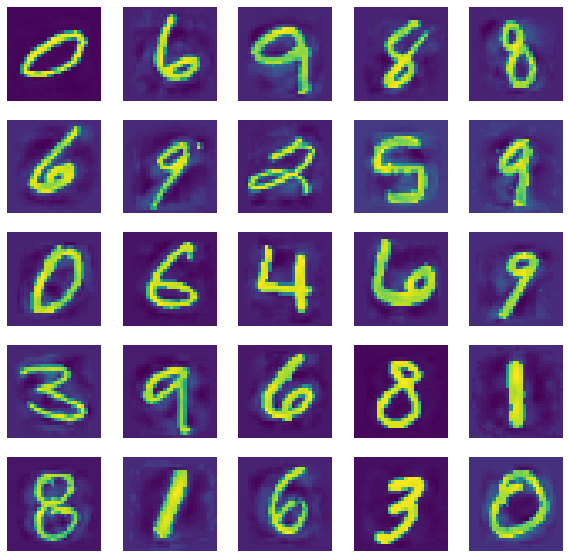

In [30]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
# imgs = c[:len(axs)]
imgs = c[-len(axs):]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

In [31]:
model.layer1.weight.data.shape#[:,0]

torch.Size([10, 100])

In [32]:
model.layer1.weight.data[:, 4]

tensor([ -5.9592,  -9.8093, -16.9262,  -5.1531,  -5.8884,  -6.9848, -15.8564,
          1.2141,  -3.6810,   7.8794])

In [33]:
# plt.hist(model.layer1.weight.data[0])
# plt.xlabel(f"Neuron: {0}")
# plt.show()

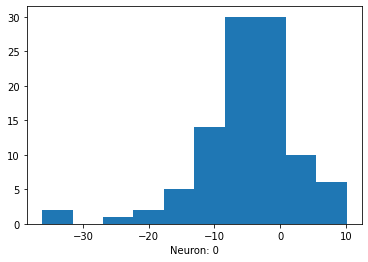

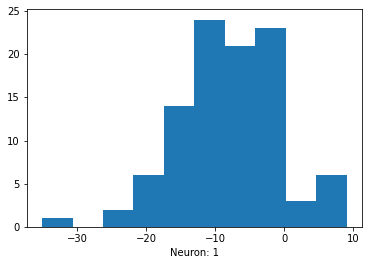

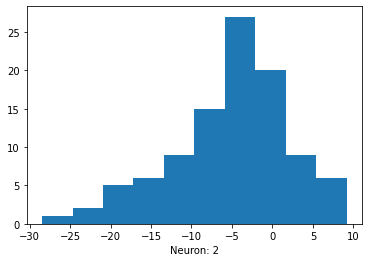

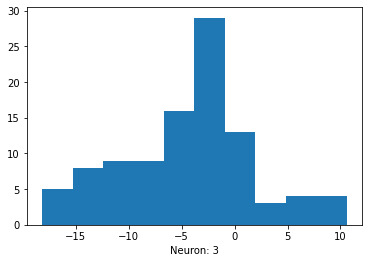

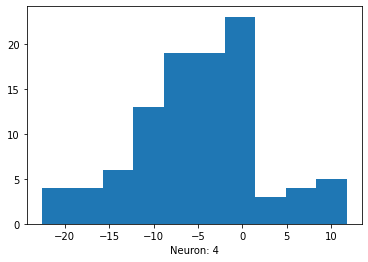

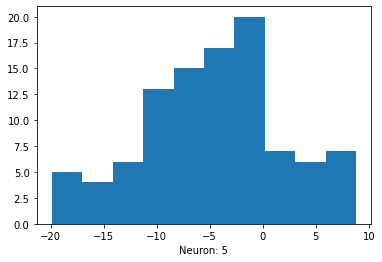

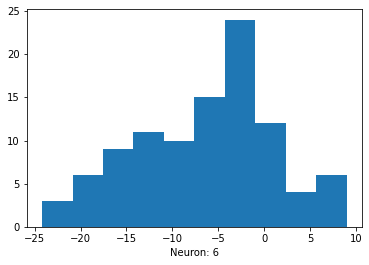

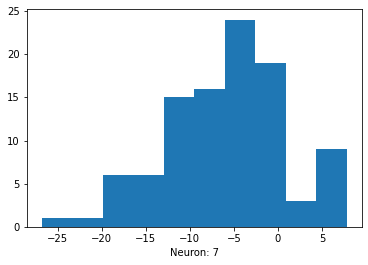

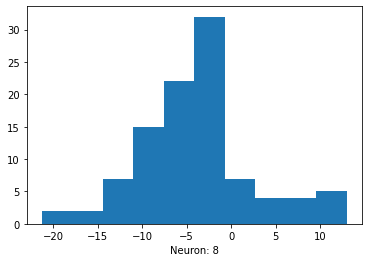

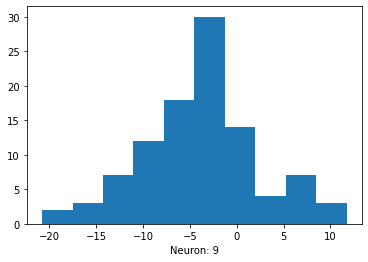

In [34]:
for i in range(model.layer1.weight.shape[0]):
    plt.hist(model.layer1.weight.data[i])
    plt.xlabel(f"Neuron: {i}")
    plt.show()

In [35]:
model.layer1.weight.data.max(dim=0)[0], model.layer1.weight.data.max(dim=0)[0].mean()

(tensor([ 6.0678,  8.1320,  8.3631, 11.3484,  7.8794,  9.0519,  7.5433,  5.6912,
          3.2981,  7.0855,  7.5189,  8.7068,  9.8960,  4.0181,  9.0538,  5.6665,
          4.7337,  5.5876,  5.4844,  4.8009,  7.0798,  6.6667,  6.2311,  9.1490,
          7.1300,  8.3668,  8.1757,  4.0602,  4.9345,  7.6311,  8.1378,  5.7619,
          7.3744,  4.9821,  5.2018,  4.8742,  4.4889,  6.1297,  7.8570,  5.0675,
          5.4317,  6.0481,  3.8137,  7.9136,  4.8300,  4.9270,  4.9981,  6.8118,
          6.4745,  8.2835,  8.8117,  7.7969, 12.9900,  5.3032,  5.6579,  5.5892,
          5.2204, 11.9155,  8.8559, 11.7213,  6.7688,  9.3171,  6.6569,  8.1146,
          7.6956, 11.7254, 10.5104,  4.0571,  9.0146,  5.7389,  6.5973,  6.9790,
          6.7384,  7.4056,  9.1551, 10.0701,  4.3784,  3.9373, 11.5161,  3.9382,
          6.6883,  7.3907,  3.8855,  5.7406,  6.6964,  5.9433,  8.9265,  9.1055,
          4.7742,  5.7506,  4.6845,  6.9738,  7.9220, 10.2356,  9.0436,  5.7851,
          8.9062,  4.9077, 1

In [36]:
model.layer1.weight.data.max(), model.layer1.weight.data.max(dim=0)[0].mean()

(tensor(12.9900), tensor(7.0222))

In [37]:
# (model.layer1.weight.data.max(dim=0)[0]**2).mean().sqrt()

In [38]:
model.layer1.weight.data.norm(dim=0, keepdim=True)

tensor([[19.9293, 27.8278, 19.6458, 28.0700, 29.2708, 26.4534, 28.5466, 31.4361,
         28.0102, 23.0938, 17.5555, 27.7580, 22.1411, 34.3466, 34.5816, 31.1639,
         20.1984, 22.9075, 33.0159, 35.4730, 21.2296, 29.6055, 25.2313, 19.1784,
         26.5030, 25.3848, 25.4940, 31.2426, 24.9578, 31.1077, 20.2250, 34.4137,
         26.9150, 32.7441, 29.9405, 37.2504, 28.4418, 28.3861, 32.5434, 20.5515,
         21.7189, 27.6818, 24.2973, 38.8210, 25.7422, 18.6355, 25.1901, 25.8241,
         23.9214, 24.8803, 35.6117, 26.1388, 24.6888, 25.4615, 25.7035, 20.0514,
         25.7320, 25.0588, 47.5020, 21.8622, 37.4353, 30.3378, 18.7801, 35.1696,
         21.2060, 25.5783, 23.3057, 26.0077, 29.4748, 31.3807, 22.7790, 24.8558,
         19.2799, 23.9167, 12.2754, 10.4545, 27.1634, 33.7913, 19.9996, 19.7560,
         26.6067, 24.8808, 25.9182, 52.6606, 39.6584, 25.5895, 13.6026, 15.4633,
         36.8333, 27.5709, 33.4734, 25.1658, 18.2420, 11.6923, 15.9945, 36.6157,
         30.2335, 31.5432, 1

In [39]:
model.layer0.bias.data

tensor([[1.1031, 1.0556, 1.1043, 0.7633, 0.7006, 0.8995, 0.7813, 1.0730, 1.1494,
         0.8633, 0.7137, 1.0738, 0.7021, 1.0728, 0.8419, 0.6670, 1.1969, 0.9667,
         0.6275, 0.8731, 0.8350, 0.8165, 0.9714, 0.6813, 0.9604, 0.9201, 0.7793,
         1.2100, 0.8399, 0.6720, 0.7947, 1.4693, 0.8497, 0.9899, 0.8722, 0.7449,
         0.8594, 1.1964, 0.9520, 0.7994, 1.0511, 0.7916, 1.1521, 0.3484, 0.6544,
         0.7189, 1.1247, 0.9682, 0.8093, 0.6401, 0.9556, 0.6676, 0.6210, 0.4997,
         0.8464, 0.7463, 0.6708, 0.5857, 0.3382, 0.7045, 0.8015, 0.6387, 1.0560,
         0.5734, 0.5799, 0.5480, 0.2077, 0.9866, 0.7071, 0.8734, 0.7862, 1.0071,
         0.8083, 0.5821, 0.7119, 0.2672, 0.6880, 0.4986, 0.8034, 0.3822, 0.7417,
         0.6250, 0.7593, 0.5471, 0.5313, 0.8758, 0.8143, 0.6932, 0.8433, 0.5703,
         0.6841, 0.5631, 0.8303, 0.7393, 0.4048, 0.5194, 0.5443, 0.5440, 0.5000,
         0.6946]])

## Observation

In [40]:
"""
1) After epochs increase, the initial neurons solidify (and produce high importance) 
    -> 92.5% test accuracy on 10 epochs (new_neurons skewed removal)
    -> credit to large output values
    -> Try value normalization (91.88% test accuracy -> maybe it trains slower ; overall removal)
    -> Try value initialization to mean (92.88% test accuracy -> overall removal)
    -> Try value initialization to (mean+max)/2 (93.15% test accuracy -> overall removal)
    
2) Resetting optimizer hamper the accuracy reached; Noisy method helps accuracy.
3) Increasing lr of centers increases accuracy (95.02%) (also deviates more from data)
4) 

"""
print()

# With Epsilon and adverserial rejection

In [496]:
h = 100
model = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=10.0)

In [497]:
N_search = 30
# N_search = 1

In [498]:
model.to(device)

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): ReLU()
  (layer1): Linear(in_features=101, out_features=10, bias=True)
)

In [499]:
## Initialization
new_center, weights = get_random_training_samples(h)
if model.layer0.epsilon is not None:
    e = torch.zeros(1, weights.shape[1])
    weights = torch.cat([weights, e], dim=0)

model.layer0.centers.data = new_center.to(device)
model.layer1.weight.data = weights.t().to(device)
# print(weights.shape)

In [500]:
test_acc = test(0, model)

[Test] 0 Loss: 2.187 | Acc: 28.080 2808/10000


In [501]:
def add_neurons_to_model(model, centers, values):
    c = torch.cat((model.layer0.centers.data, centers), dim=0)
    v = torch.cat((model.layer1.weight.data[:,:-1], values.t(), model.layer1.weight.data[:,-1:]), dim=1)
    s = torch.cat([model.layer0.bias.data[:,:-1], torch.ones(1, len(centers))*0, model.layer0.bias.data[:,-1:]], dim=1)

    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [502]:
add_neurons_to_model(model, *get_random_training_samples(N_search))

In [503]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([130, 784]), torch.Size([10, 131]))

In [504]:
def remove_neurons_from_model(model, importance, num_prune):
    N = model.layer0.centers.shape[0]
    importance = importance[:N]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    removing = torch.topk(importance, k=num_prune, largest=False)[1]
    print(f"Removing:\n{removing.data.sort()[0]}")
    
    c = model.layer0.centers.data[topk_idx]
    ## modifying for value tensor and bias (for epsilon value)
    topk_idx = torch.cat([topk_idx, torch.tensor([N], dtype=topk_idx.dtype)])
    s = model.layer0.bias.data[:,topk_idx]
    v = model.layer1.weight.data[:,topk_idx]
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [505]:
significance = torch.zeros(model.layer0.centers.shape[0]+1)

forw_hook = model.softmax.register_forward_hook(capture_outputs)
back_hook = model.softmax.register_backward_hook(capture_gradients)

for xx, yy in tqdm(train_loader):
    xx = xx.to(device).view(-1, 28*28)
    ## Rescale the values to unit norm
#     model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)

    yout = model(xx)

    none_grad()
#     yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
    ####################################
#     grad = torch.randn_like(yout)
#     ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#     yout.backward(gradient=grad)
    ###################################
    loss = criterion(yout, yy)
    loss.backward()
    with torch.no_grad():
        significance += torch.sum((outputs*gradients)**2, dim=0)
        
remove_hook()
none_grad()

significance.shape

100%|██████████| 1200/1200 [00:08<00:00, 138.04it/s]


torch.Size([131])

In [506]:
outputs, gradients = None, None

In [507]:
remove_neurons_from_model(model, significance, N_search)

Removing:
tensor([ 10,  12,  14,  19,  26,  29,  31,  41,  42,  43,  46,  53,  56,  58,
         73,  80,  87,  89,  91,  93,  99, 101, 103, 108, 112, 118, 120, 123,
        125, 127])


In [508]:
model.layer0.centers.data.shape, model.layer1.weight.data.shape

(torch.Size([100, 784]), torch.Size([10, 101]))

In [509]:
# model.layer1.weight.data

In [510]:
test_acc = test(0, model)

[Test] 0 Loss: 2.180 | Acc: 29.170 2917/10000


In [511]:
learning_rate = 0.01

p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": learning_rate*0.03}, ## default - to change little from data point
#     {"params": p1},
    {"params": p2},
]

In [512]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [513]:
## Run multiple times for convergence
EPOCHS = 2 # 10

for s in range(EPOCHS):
    model.train()
    print(f"Adding, Finetuening and Pruning for STEP: {s}")
    ### Resetting optimizer every removal of neuron
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    c, v = get_random_training_samples(N_search)
#     v *= model.layer1.weight.data.max(dim=0)[0].mean()
    v *= (model.layer1.weight.data.max() + model.layer1.weight.data.max(dim=0)[0].mean())/2
    add_neurons_to_model(model, c, v)
    
    significance = torch.zeros(model.layer0.centers.shape[0]+1)

    forw_hook = model.softmax.register_forward_hook(capture_outputs)
    back_hook = model.softmax.register_backward_hook(capture_gradients)
    
    for xx, yy in tqdm(train_loader):
        xx = xx.to(device).view(-1, 28*28)
        ## Rescale the values to unit norm
#         model.layer1.weight.data /= model.layer1.weight.data.norm(dim=0, keepdim=True)
        
        yout = model(xx)

        none_grad()
#         yout.register_hook(lambda grad: grad/(torch.norm(grad, dim=1, keepdim=True)+1e-9))
        ####################################
#         grad = torch.randn_like(yout)
#         ### grad = grad/torch.norm(grad, dim=1, keepdim=True)
#         yout.backward(gradient=grad)
        ###################################
        loss = criterion(yout, yy)
        loss.backward()
        with torch.no_grad():
            significance += torch.sum((outputs*gradients)**2, dim=0)
            
        optimizer.step()

    remove_hook()
    remove_neurons_from_model(model, significance, N_search)
    test_acc3 = test(0, model)
#     print(f"Accuracy: {test_acc3}")

## Finetune after finishing removal to get better performance ??

Adding, Finetuening and Pruning for STEP: 0


100%|██████████| 1200/1200 [00:10<00:00, 114.13it/s]

Removing:
tensor([  3,   5,   7,   8,  16,  20,  22,  27,  29,  31,  32,  36,  41,  48,
         50,  51,  54,  57,  62,  64,  73,  76,  81,  83,  96, 102, 105, 107,
        113, 121])


[Test] 0 Loss: 0.388 | Acc: 88.000 8800/10000
Adding, Finetuening and Pruning for STEP: 1


100%|██████████| 1200/1200 [00:11<00:00, 107.21it/s]

Removing:
tensor([ 68,  72,  78,  83,  88,  91,  92,  93,  94,  95,  96,  98,  99, 100,
        102, 104, 105, 107, 108, 109, 110, 112, 113, 116, 119, 122, 124, 125,
        127, 128])


[Test] 0 Loss: 0.299 | Acc: 90.750 9075/10000


In [514]:
gradients.shape

torch.Size([50, 131])

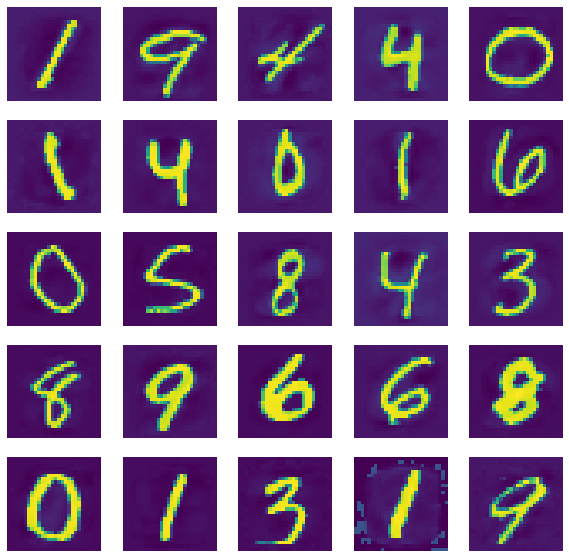

In [515]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
# imgs = c[:len(axs)]
imgs = c[-len(axs):]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

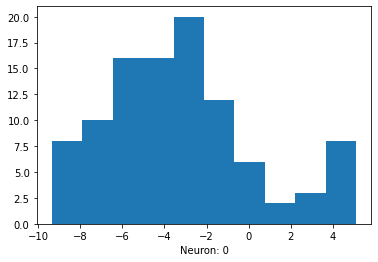

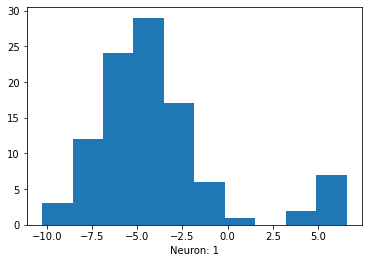

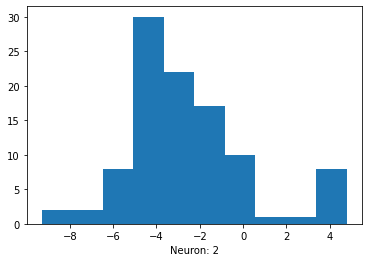

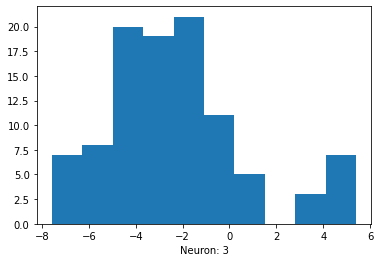

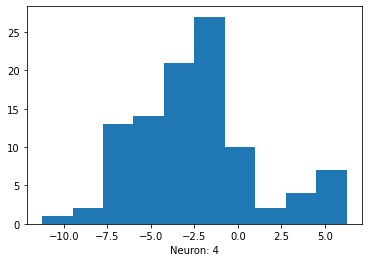

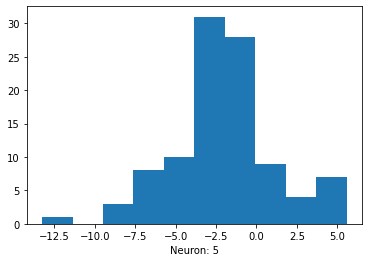

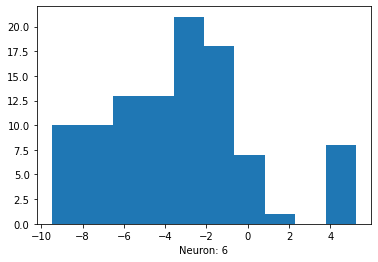

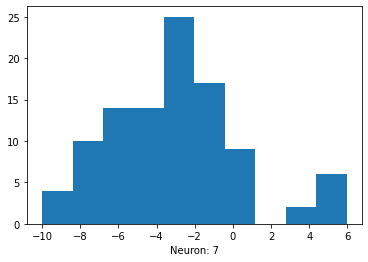

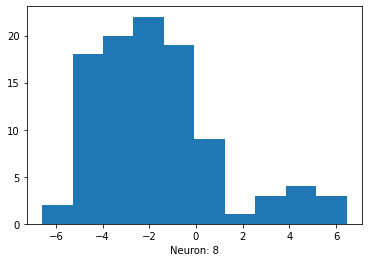

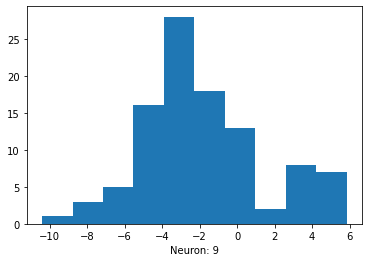

In [516]:
for i in range(model.layer1.weight.shape[0]):
    plt.hist(model.layer1.weight.data[i])
    plt.xlabel(f"Neuron: {i}")
    plt.show()

## Test for Adverserial Examples for e-Softmax

In [ ]:
## Copied from: 02.5_MaT_epsilonSoftmax_sample_rejection_and_adverserial_comparision_MNIST

In [522]:
import foolbox as fb
import foolbox.attacks as fa

In [601]:
model_ = LocalMLP_epsilonsoftmax(784, h, 10, epsilon=0.5)

In [602]:
model_.layer0.centers.data = model.layer0.centers.data
model_.layer0.scaler.data = model.layer0.scaler.data
model_.layer0.bias.data = model.layer0.bias.data
model_.layer1.weight.data = model.layer1.weight.data
model_.layer1.bias.data = model.layer1.bias.data

In [603]:
outputs, gradients = None, None
none_grad()

In [604]:
for n, p in model.named_parameters():
    print(n, p.grad)

layer0.centers None
layer0.scaler None
layer0.bias None
layer1.weight None
layer1.bias None


In [605]:
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [606]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    with torch.no_grad():
        yout = model_(xx)
    reject = model_.temp_maximum.max(dim=1)[1] == model_.hidden_dim
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)
    with torch.no_grad():
        yout = model_(advs)
    reject = model_.temp_maximum.max(dim=1)[1] == model_.hidden_dim
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

100%|██████████| 200/200 [00:02<00:00, 96.58it/s] 


In [607]:
count, failed, rejected, x_rejected

(10000, 2426, 7057, 1030)

In [608]:
(failed+x_rejected)/count

0.3456

In [532]:
# model_.layer0.epsilon = 5.0